In [1]:
import scvelo as scv
import dynamo as dyn
import numpy as np
import scanpy as sc
import cellrank as cr
import wandb
import magic
import anndata

In [2]:
adata = cr.datasets.pancreas()

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [4]:
# sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=30, n_pcs=30)
sc.tl.leiden(adata, resolution=15)
# sc.pl.umap(adata, color=['leiden'])

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class ODE_Net(nn.Module):
    def __init__(self, feature_dim):
        super(ODE_Net, self).__init__()
        self.fc1 = nn.Linear(1, 128)  # Input is time t
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, feature_dim) 
        self.fc4 = nn.Linear(128, feature_dim) 
        # Define log_alpha, log_beta, and log_gamma to ensure they are positive after exponentiation
        self.log_alpha = nn.Parameter(torch.rand(feature_dim))
        self.log_beta = nn.Parameter(torch.rand(feature_dim))
        self.log_gamma = nn.Parameter(torch.rand(feature_dim))

    def forward(self, t):
        t = torch.relu(self.fc1(t))
        t = torch.relu(self.fc2(t))
        x1 = self.fc3(t)
        x2 = self.fc4(t)
        return x1, x2

    # Expose alpha, beta, and gamma as properties
    @property
    def alpha(self):
        return torch.exp(self.log_alpha)

    @property
    def beta(self):
        return torch.exp(self.log_beta)

    @property
    def gamma(self):
        return torch.exp(self.log_gamma)

# Define the custom loss function
def custom_loss(t, true_x, model, feature_dim):
    # Get the model predictions
    pred_x1, pred_x2 = model(t)
    

    # Compute the gradients
    pred_x1_grad = torch.autograd.grad(pred_x1, t, torch.ones_like(pred_x1), create_graph=True)[0]
    pred_x2_grad = torch.autograd.grad(pred_x2, t, torch.ones_like(pred_x2), create_graph=True)[0]

    # Data mismatch loss
    loss_data = torch.mean((true_x[:, :feature_dim] - pred_x1) ** 2) + torch.mean((true_x[:, feature_dim:] - pred_x2) ** 2)

    # Physics-informed loss
    loss_physics = torch.mean((pred_x1_grad - (model.alpha - model.beta * pred_x1)) ** 2, dim=1).mean() + \
                   torch.mean((pred_x2_grad - (model.beta * pred_x1 - model.gamma * pred_x2)) ** 2, dim=1).mean()

    return loss_data + loss_physics

# Function to train the model and return the learned parameters
def estimate_parameters(X1, X2, t, epochs=5000, lr=0.001):
    # Check if CUDA is available and set the device accordingly
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    n_samples, feature_dim = X1.shape[0], X1.shape[1]  # Number of features for X1 and X2
    model = ODE_Net(feature_dim).to(device)
    
    # Combine X1 and X2 for convenience and send to device
    x_data = torch.cat((X1, X2), dim=1).to(device)
    
    # Convert t to a tensor, reshape for input to the model, and send to device
    t_data = torch.tensor(t, requires_grad=True).view(-1, 1).to(device)
    
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = custom_loss(t_data, x_data, model, feature_dim=feature_dim)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # After training, return the learned parameters
    alpha_learned = model.alpha.expand(n_samples, -1).detach().cpu().numpy()
    beta_learned = model.beta.expand(n_samples, -1).detach().cpu().numpy()
    gamma_learned = model.gamma.expand(n_samples, -1).detach().cpu().numpy()
    return alpha_learned, beta_learned, gamma_learned
    


In [6]:
adata_list = []
for i in adata.obs['clusters'].value_counts().index:
    adata_i = adata[adata.obs['clusters'] == i].copy()
    X1_i = adata_i.layers['Mu']
    X2_i = adata_i.layers['Ms']
    t_i = adata_i.obs['palantir_pseudotime'].values
    alpha, beta, gamma = estimate_parameters(torch.tensor(X1_i, dtype=torch.float32),
                                             torch.tensor(X2_i, dtype=torch.float32),
                                             torch.tensor(t_i, dtype=torch.float32))
    adata_i.layers['alpha'] = alpha
    adata_i.layers['beta'] = beta
    adata_i.layers['gamma'] = gamma
    
    adata_list.append(adata_i)

adata = anndata.concat(adata_list, axis=0)


Using device: cuda


/home/cys/miniconda3/envs/velo/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 999, Loss: 23.53439712524414
Epoch 1999, Loss: 18.919185638427734
Epoch 2999, Loss: 18.877737045288086
Epoch 3999, Loss: 18.871152877807617
Epoch 4999, Loss: 18.868837356567383
Using device: cuda


/home/cys/miniconda3/envs/velo/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 999, Loss: 3.98128080368042
Epoch 1999, Loss: 3.270638942718506
Epoch 2999, Loss: 3.2479019165039062
Epoch 3999, Loss: 3.2410221099853516
Epoch 4999, Loss: 3.2382349967956543
Using device: cuda


/home/cys/miniconda3/envs/velo/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 999, Loss: 7.057890892028809
Epoch 1999, Loss: 0.8356581926345825
Epoch 2999, Loss: 0.8051317930221558
Epoch 3999, Loss: 0.7983354330062866
Epoch 4999, Loss: 0.7949826717376709
Using device: cuda


/home/cys/miniconda3/envs/velo/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 999, Loss: 14.983481407165527
Epoch 1999, Loss: 14.348634719848633
Epoch 2999, Loss: 14.30751895904541
Epoch 3999, Loss: 14.30302906036377
Epoch 4999, Loss: 14.315220832824707
Using device: cuda


/home/cys/miniconda3/envs/velo/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 999, Loss: 11.580361366271973
Epoch 1999, Loss: 9.62366008758545
Epoch 2999, Loss: 9.547526359558105
Epoch 3999, Loss: 9.563481330871582
Epoch 4999, Loss: 9.536076545715332
Using device: cuda


/home/cys/miniconda3/envs/velo/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 999, Loss: 4.990488529205322
Epoch 1999, Loss: 0.10644741356372833
Epoch 2999, Loss: 0.12265893816947937
Epoch 3999, Loss: 0.08529596030712128
Epoch 4999, Loss: 0.09075978398323059
Using device: cuda


/home/cys/miniconda3/envs/velo/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 999, Loss: 7.8915486335754395
Epoch 1999, Loss: 6.392140865325928
Epoch 2999, Loss: 6.35304069519043
Epoch 3999, Loss: 6.316351890563965
Epoch 4999, Loss: 6.322270393371582


In [7]:
i = 910

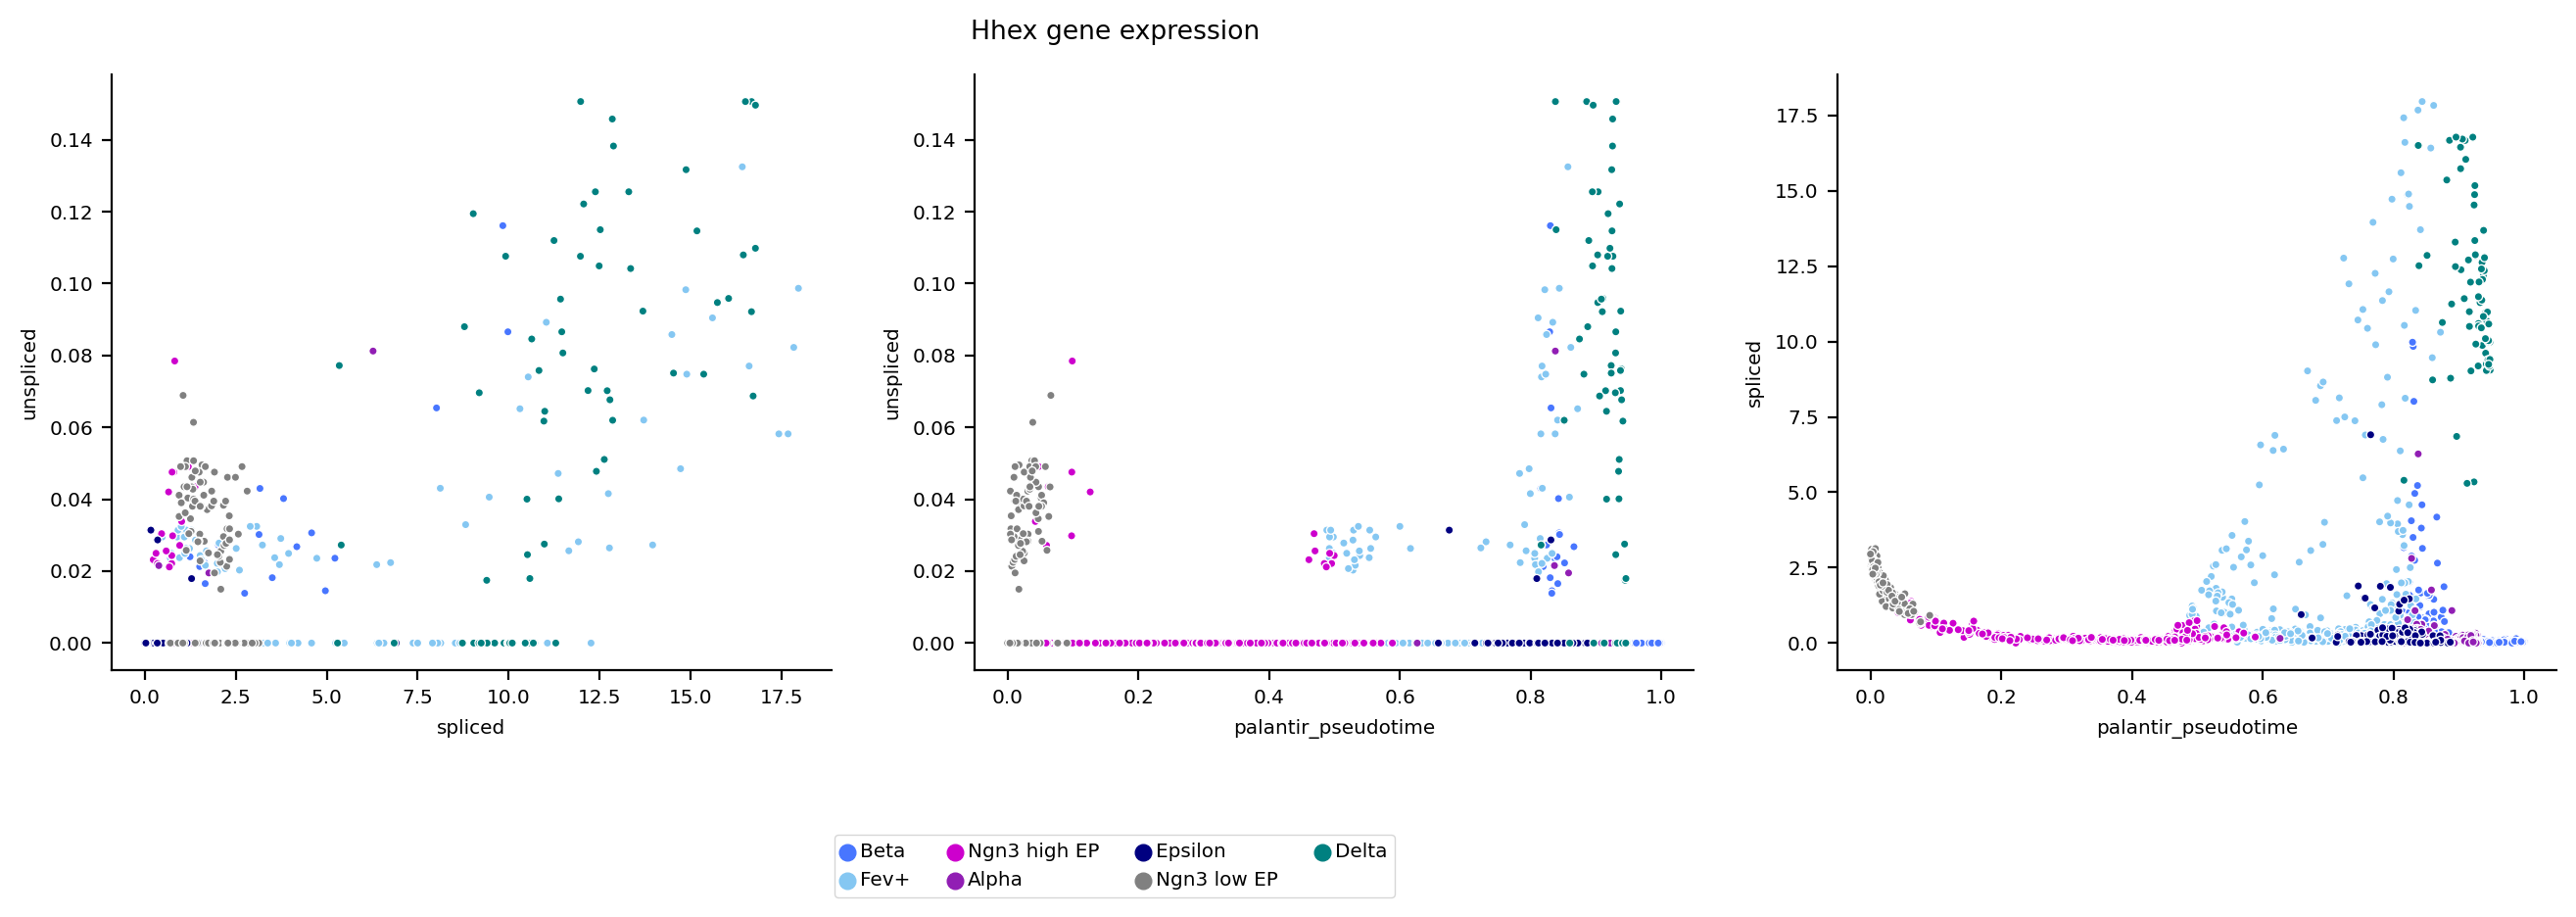

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot 1
sns.scatterplot(x=np.array(adata.layers['Ms'][:, i]).reshape(-1),
                y=np.array(adata.layers['Mu'][:, i]).reshape(-1),
                hue=adata.obs['clusters'], marker='.', ax=axes[0])
axes[0].set_ylabel('unspliced')
axes[0].set_xlabel('spliced')
axes[0].get_legend().remove()

# Plot 2
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=np.array(adata.layers['Mu'][:, i]).reshape(-1),
                hue=adata.obs['clusters'], marker='.', ax=axes[1])
axes[1].set_ylabel('unspliced')
axes[1].set_xlabel('palantir_pseudotime')
axes[1].get_legend().remove()

# Plot 3
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=np.array(adata.layers['Ms'][:, i]).reshape(-1),
                hue=adata.obs['clusters'], marker='.', ax=axes[2])
axes[2].set_ylabel('spliced')
axes[2].set_xlabel('palantir_pseudotime')
axes[2].get_legend().remove()

# Remove top and right spines
for j in range(3):
    axes[j].spines['top'].set_visible(False)
    axes[j].spines['right'].set_visible(False)
handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle(adata.var.iloc[i].name+' gene expression')
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=4)

plt.show()


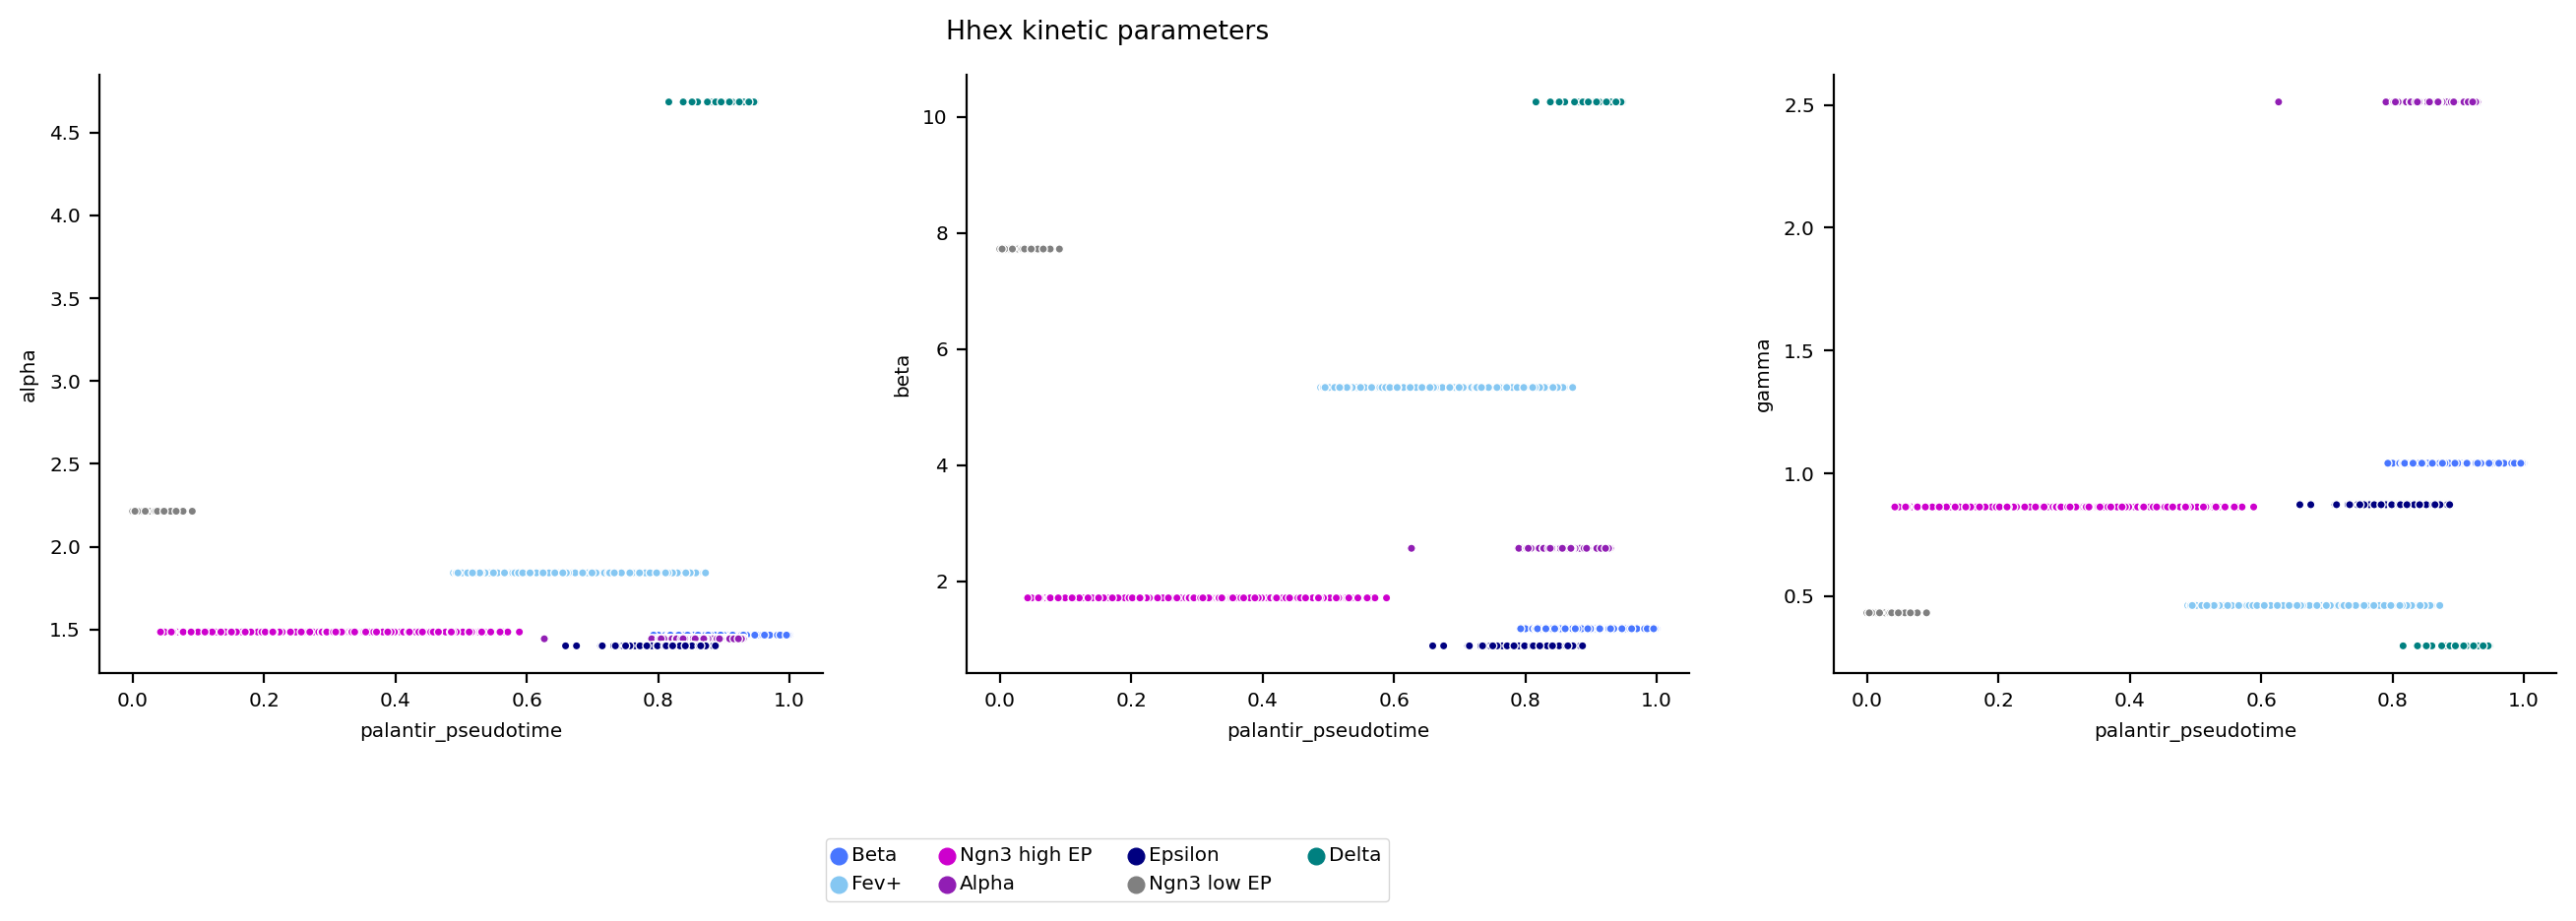

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot 1
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=adata.layers['alpha'][:, i],
                hue=adata.obs['clusters'], marker='.', ax=axes[0])
axes[0].set_ylabel('alpha')
axes[0].set_xlabel('palantir_pseudotime')
axes[0].get_legend().remove()

# Plot 2
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=adata.layers['beta'][:, i],
                hue=adata.obs['clusters'], marker='.', ax=axes[1])
axes[1].set_ylabel('beta')
axes[1].set_xlabel('palantir_pseudotime')
axes[1].get_legend().remove()

# Plot 3
sns.scatterplot(x=adata.obs['palantir_pseudotime'],
                y=adata.layers['gamma'][:, i],
                hue=adata.obs['clusters'], marker='.', ax=axes[2])
axes[2].set_ylabel('gamma')
axes[2].set_xlabel('palantir_pseudotime')
axes[2].get_legend().remove()

# Remove top and right spines
for j in range(3):
    axes[j].spines['top'].set_visible(False)
    axes[j].spines['right'].set_visible(False)

# Get handles and labels for the legend
handles, labels = axes[0].get_legend_handles_labels()

fig.suptitle(adata.var.iloc[i].name+' kinetic parameters')

# Create a single legend
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=4)

plt.show()